## Hate Text detection

Dataset: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

# Importing Required Libraries

In [51]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
tweet_df = pd.read_csv('/content/train.csv')
tweet_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [53]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [54]:
print(tweet_df['tweet'].iloc[0],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 



# Data Preprocessing
* Removing links,mails,more than one spaces
* Tokenization using NLTK
* Removing stop words

In [55]:
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [56]:
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)
tweet_df = tweet_df.drop_duplicates('tweet')

* Lemmatization Using NLTK

In [57]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return tweet

In [58]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))

In [59]:
print(tweet_df['tweet'].iloc[0],"\n")

user father dysfunctional selfish drags kids dysfunction run 



In [60]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29345 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29345 non-null  int64 
 1   label   29345 non-null  int64 
 2   tweet   29345 non-null  object
dtypes: int64(2), object(1)
memory usage: 917.0+ KB


In [61]:
tweet_df['label'].value_counts()

0    27352
1     1993
Name: label, dtype: int64

# Data Visualization

<Axes: xlabel='label', ylabel='count'>

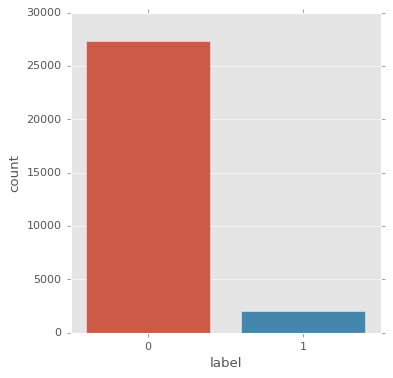

In [62]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = tweet_df)

Text(0.5, 1.0, 'Distribution of sentiments')

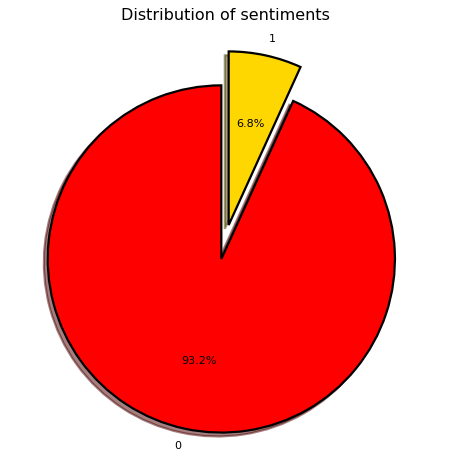

In [63]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_df['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90,
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [64]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
non_hate_tweets.head()

,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time ur
4,5,0,factsguide society motivation


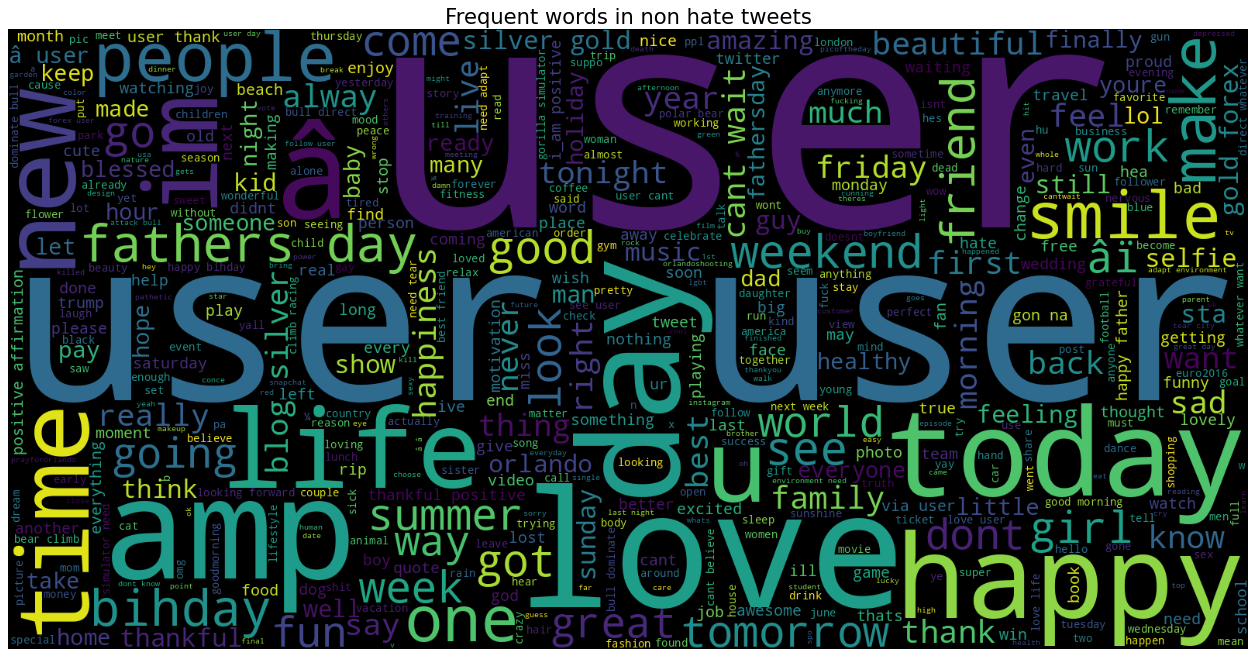

In [65]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent words in non hate tweets', fontsize = 19)
plt.show()

In [66]:
hate_tweets = tweet_df[tweet_df.label == 1]
hate_tweets.head()

,id,label,tweet
13,14,1,user cnn calls michigan middle school build wa...
14,15,1,comment australia opkillingbay seashepherd hel...
17,18,1,retweet agree
23,24,1,user user lumpy says prove lumpy
34,35,1,unbelievable 21st century wed need something l...


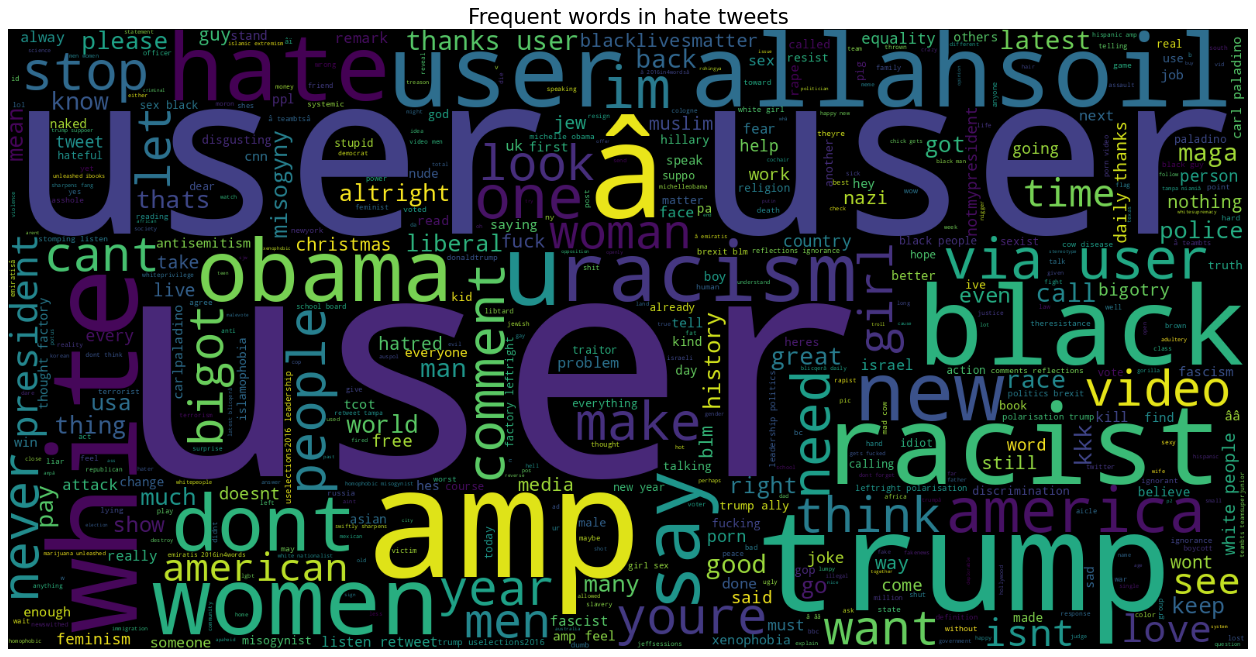

In [67]:
text = ' '.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent words in hate tweets', fontsize = 19)
plt.show()

# Text Representation(Vectorization)
* Use of TfIdf -> Text frequency - Inverse document frequency using sklearn

In [68]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

In [69]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 10 features: \n{}".format(feature_names[:10]))

Number of features: 208579

First 10 features: 
['0000001' '0000001 polluting' '00027' '00027 photooftheday' '001' '0035'
 '00h30' '01' '01 4995' '01 7900']


In [70]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(tweet_df['tweet'])

In [71]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 10 features: \n{}".format(feature_names[:10]))

Number of features: 380305

First 10 features: 
['0000001' '0000001 polluting' '0000001 polluting niger' '00027'
 '00027 photooftheday' '00027 photooftheday music' '001' '0035' '00h30'
 '01']


# Model building

In [72]:
X = tweet_df['tweet']
Y = tweet_df['label']
X = vect.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (23476, 380305)
Size of y_train: (23476,)
Size of x_test:  (5869, 380305)
Size of y_test:  (5869,)


# Hyperparameter tuning using GridSearchCV

In [74]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [75]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid_logit = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid_logit.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid_logit.best_score_))
print("Best parameters: ", grid_logit.best_params_)

Best Cross validation score: 0.95
Best parameters:  {'C': 100, 'solver': 'newton-cg'}


In [76]:
logreg = LogisticRegression(C=100,solver= 'newton-cg')
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

Test accuarcy: 94.89%


[[5450    8]
 [ 292  119]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5458
           1       0.94      0.29      0.44       411

    accuracy                           0.95      5869
   macro avg       0.94      0.64      0.71      5869
weighted avg       0.95      0.95      0.94      5869



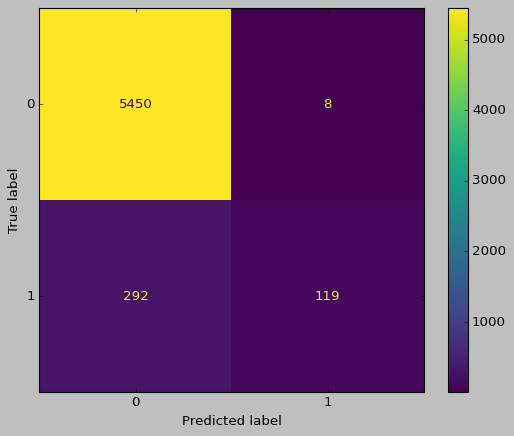

In [77]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [78]:
des = DecisionTreeClassifier()
des.fit(x_train, y_train)
des_predict = des.predict(x_test)
des_acc = accuracy_score(des_predict, y_test)
print("Test accuarcy: {:.2f}%".format(des_acc*100))

Test accuarcy: 94.50%


In [79]:
print(des.tree_.max_depth)

1190


In [80]:
des2 = DecisionTreeClassifier(criterion='entropy')
des2.fit(x_train, y_train)
des2_predict = des2.predict(x_test)
des2_acc = accuracy_score(des2_predict, y_test)
print("Test accuarcy: {:.2f}%".format(des2_acc*100))

Test accuarcy: 94.14%


In [81]:
print(des2.tree_.max_depth)

1102


In [82]:
svc = SVC()
svc.fit(x_train, y_train)
svc_predict = svc.predict(x_test)
svc_acc = accuracy_score(svc_predict, y_test)
print("Test accuarcy: {:.2f}%".format(svc_acc*100))

Test accuarcy: 93.99%


In [83]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_predict=knn.predict(x_test)
knn_acc = accuracy_score(knn_predict,y_test)
print("Test accuarcy: {:.2f}%".format(knn_acc*100))

Test accuarcy: 94.43%


In [84]:
print(logreg.predict(x_test[20:30]))
print(des.predict(x_test[20:30]))
print(des2.predict(x_test[20:30]))
print(svc.predict(x_test[20:30]))
print(knn.predict(x_test[20:30]))
print("Actual",y_test[20:30].values)

[0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Actual [0 0 0 0 1 0 0 1 0 0]


In [91]:
def GetHateOrNonhate(text):
  text = data_processing(text)
  text = lemmatizing(text)
  text =  vect.transform([text])
  pred = logreg.predict(text)
  if(pred):
    print("Hate")
  else:
    print("Non Hate")

s = 'I love my cunning friend.'
t = 'Africans is Black people!'
GetHateOrNonhate(s)
GetHateOrNonhate(t)

Non Hate
Hate
